# Predicting Future Stock Prices

**Objective:** Use historical stock market data to predict the **next day's closing price**

**Dataset:** Real-time data fetched from **Yahoo Finance** via the `yfinance` Python library.

**Models Used:**
- Linear Regression (baseline)
- Random Forest Regressor (advanced)

## 1.Install & Import Libraries

In [1]:
import subprocess, sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "yfinance", "--quiet"])

0

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 110
plt.rcParams['figure.figsize'] = (12, 5)

## Fetch Stock Data via yfinance

I used **Apple Inc. (AAPL)** as our target stock.  

In [44]:
#Configuration 
TICKER    = "AAPL"        
PERIOD    = "2y"          
INTERVAL  = "1d"          

print(f"Fetching {TICKER} data for the last {PERIOD}...")
stock = yf.Ticker(TICKER)
df = stock.history(period=PERIOD, interval=INTERVAL)

# Keep only OHLCV columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None)   # Remove timezone for cleaner plotting

print(f"\nDownloaded {len(df)} trading days of data.")
print(f"Date range: {df.index.min().date()}  →  {df.index.max().date()}")
print(f"\nFirst 5 rows:")
df.head()

Fetching AAPL data for the last 2y...

Downloaded 502 trading days of data.
Date range: 2024-02-14  →  2026-02-13

First 5 rows:


,Open,High,Low,Close,Volume
Date,,,,,
2024-02-14,183.648643,183.856740,180.794612,182.489182,54630500
2024-02-15,181.894611,182.826136,179.714455,182.201813,65434500
2024-02-16,181.765777,183.182888,180.031559,180.665787,49752500
2024-02-20,180.150453,180.784680,178.376603,179.922531,53665600
2024-02-21,180.299112,181.240541,179.030657,180.675690,41371400


In [6]:
print("Dataset shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())
print("\nBasic Statistics:")
df.describe().round(2)

Dataset shape: (502, 5)

Missing values:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Basic Statistics:


,Open,High,Low,Close,Volume
count,502.00,502.00,502.00,502.00,5.020000e+02
mean,222.94,225.32,220.77,223.10,5.551681e+07
std,29.69,29.78,29.47,29.65,2.737878e+07
min,163.86,164.90,162.60,163.51,1.791060e+07
25%,203.74,206.46,200.36,202.67,4.096055e+07
50%,223.72,225.80,221.83,224.43,4.878595e+07
75%,242.90,244.83,240.56,243.19,6.037098e+07
max,285.93,288.35,283.04,285.92,3.186799e+08


## 3.Exploratory Data Analysis

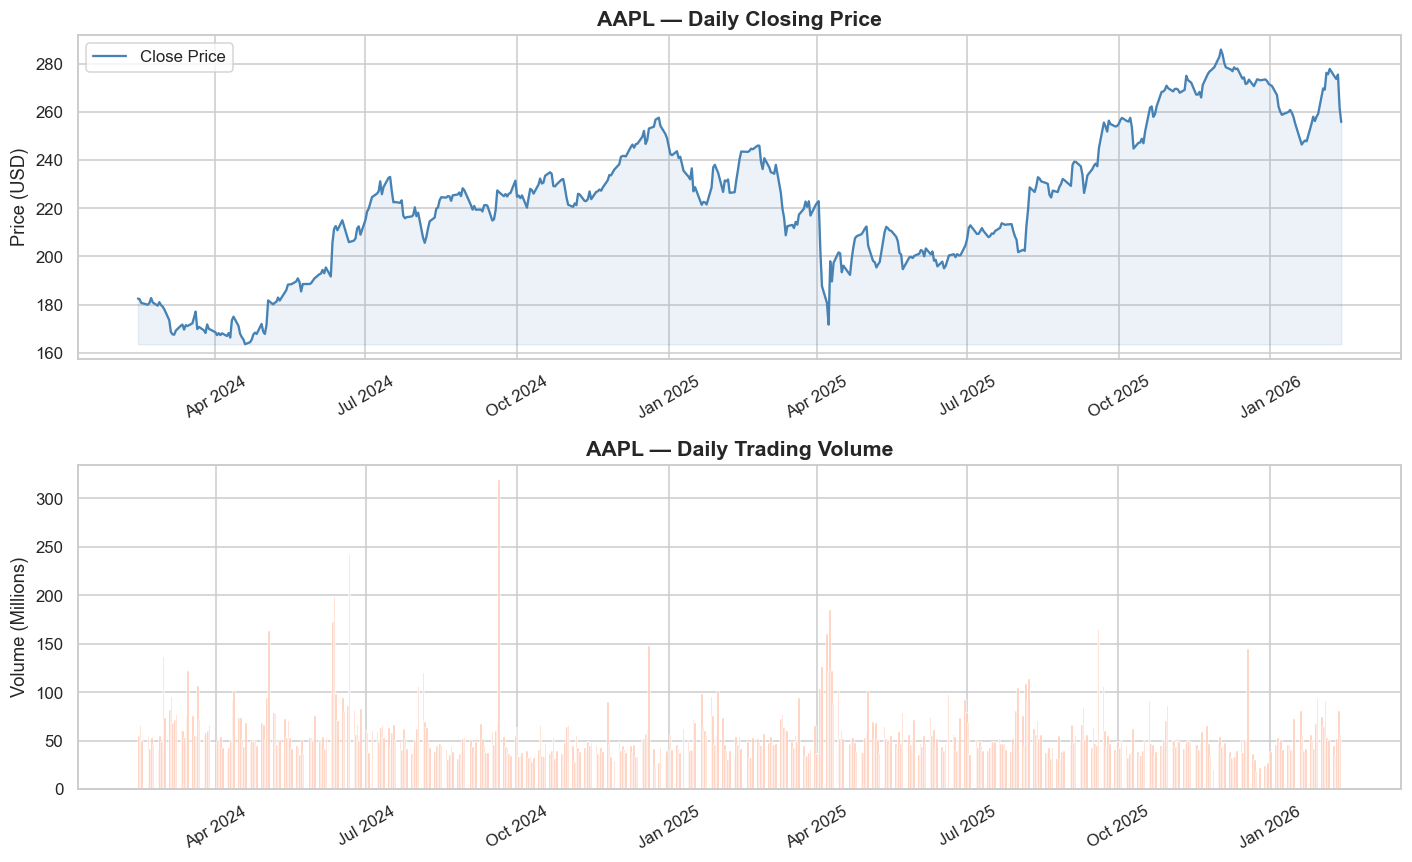

In [7]:
# Closing price history
fig, axes = plt.subplots(2, 1, figsize=(13, 8))

# Price
axes[0].plot(df.index, df['Close'], color='steelblue', linewidth=1.5, label='Close Price')
axes[0].fill_between(df.index, df['Close'], df['Close'].min(), alpha=0.1, color='steelblue')
axes[0].set_title(f'{TICKER} — Daily Closing Price', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USD)')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axes[0].tick_params(axis='x', rotation=30)
axes[0].legend()

# Volume
axes[1].bar(df.index, df['Volume'] / 1e6, color='coral', alpha=0.7, width=1)
axes[1].set_title(f'{TICKER} — Daily Trading Volume', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volume (Millions)')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

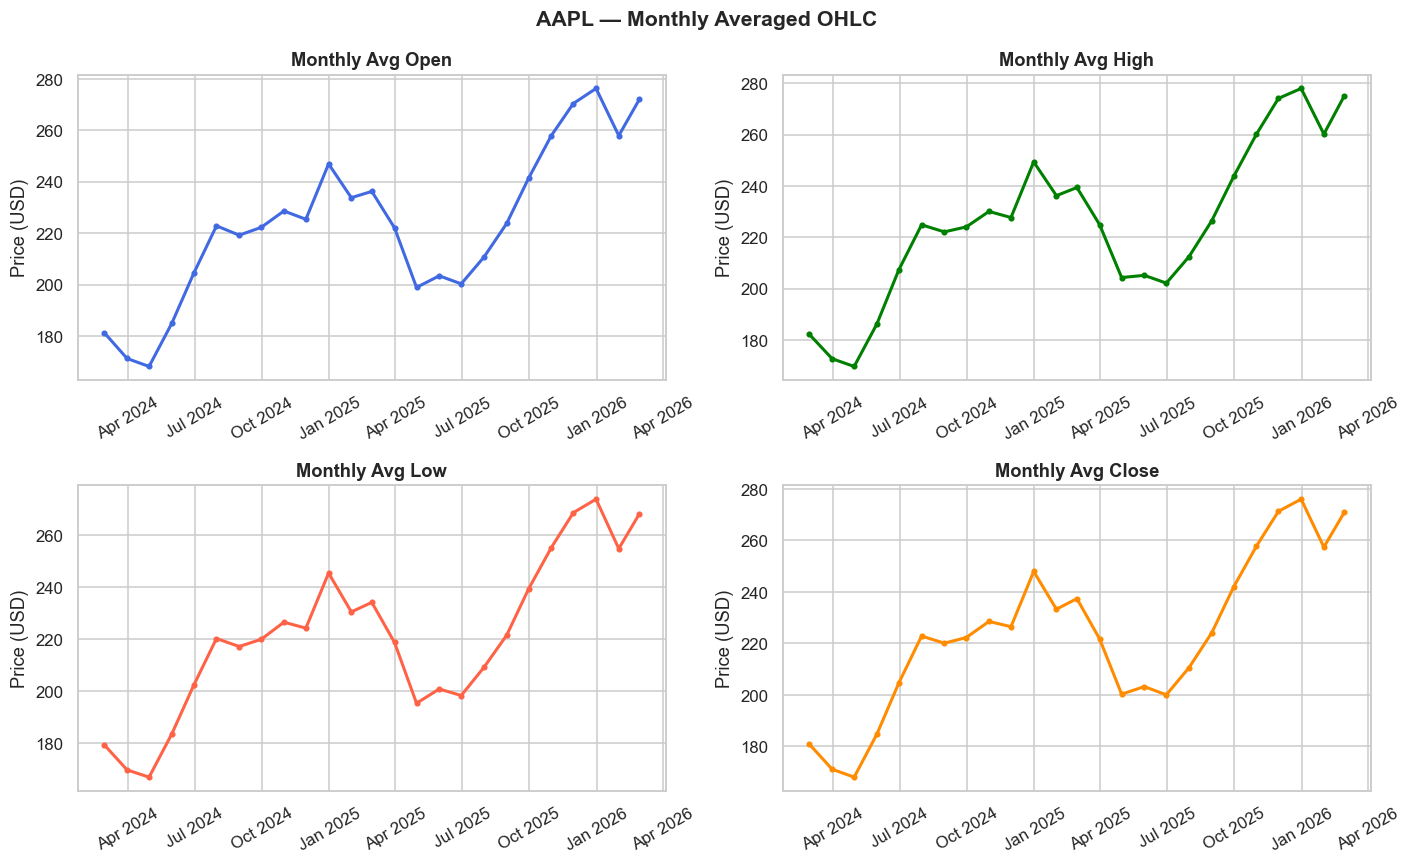

In [8]:
# Candlestick-style OHLC summary — plot monthly averages
monthly = df.resample('ME').mean(numeric_only=True)

fig, axes = plt.subplots(2, 2, figsize=(13, 8))
for ax, col, color in zip(axes.flatten(),
                           ['Open','High','Low','Close'],
                           ['royalblue','green','tomato','darkorange']):
    ax.plot(monthly.index, monthly[col], color=color, linewidth=2, marker='o', markersize=3)
    ax.set_title(f'Monthly Avg {col}', fontweight='bold')
    ax.set_ylabel('Price (USD)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.tick_params(axis='x', rotation=30)

plt.suptitle(f'{TICKER} — Monthly Averaged OHLC', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4.Feature Engineering

We create several technical indicators as model features:
- **Lag features** — previous day's Close, Volume
- **Rolling averages** — 5-day and 10-day moving averages
- **Price range** — High − Low (daily volatility)
- **Price change** — Close − Open
- **Target** — next day's Close price (`Close_Next`)

In [9]:
df_feat = df.copy()

# Lag features
df_feat['Close_Lag1']  = df_feat['Close'].shift(1)
df_feat['Close_Lag2']  = df_feat['Close'].shift(2)
df_feat['Volume_Lag1'] = df_feat['Volume'].shift(1)

# Rolling statistics
df_feat['MA_5']  = df_feat['Close'].rolling(window=5).mean()
df_feat['MA_10'] = df_feat['Close'].rolling(window=10).mean()
df_feat['Std_5'] = df_feat['Close'].rolling(window=5).std()

# Derived features
df_feat['Price_Range']  = df_feat['High']  - df_feat['Low']
df_feat['Price_Change'] = df_feat['Close'] - df_feat['Open']
df_feat['Pct_Change']   = df_feat['Close'].pct_change() * 100

# Target: next day's closing price
df_feat['Close_Next'] = df_feat['Close'].shift(-1)

# Drop NaN rows created by shifting/rolling
df_feat.dropna(inplace=True)

print(f"Feature matrix shape: {df_feat.shape}")
print(f"\nFeature columns:")
print([c for c in df_feat.columns if c != 'Close_Next'])
df_feat.head()

Feature matrix shape: (492, 15)

Feature columns:
['Open', 'High', 'Low', 'Close', 'Volume', 'Close_Lag1', 'Close_Lag2', 'Volume_Lag1', 'MA_5', 'MA_10', 'Std_5', 'Price_Range', 'Price_Change', 'Pct_Change']


,Open,High,Low,Close,Volume,Close_Lag1,Close_Lag2,Volume_Lag1,MA_5,MA_10,Std_5,Price_Range,Price_Change,Pct_Change,Close_Next
Date,,,,,,,,,,,,,,,
2024-02-28,180.863995,181.468494,178.505469,179.783829,48953900,180.982910,179.526169,54318900.0,180.774805,180.982910,1.257816,2.963024,-1.080166,-0.662538,179.119873
2024-02-29,179.635188,180.923466,177.910875,179.119873,136682600,179.783829,180.982910,48953900.0,180.057339,180.645976,0.830553,3.012592,-0.515315,-0.369308,178.039688
2024-03-01,177.930680,178.901837,175.780252,178.039688,73563100,179.119873,179.783829,136682600.0,179.490494,180.229764,1.067336,3.121585,0.109009,-0.603051,173.520828
2024-03-04,174.561346,175.304582,172.222630,173.520828,81510100,178.039688,179.119873,73563100.0,178.289426,179.515268,2.871395,3.081952,-1.040518,-2.538119,168.585724
2024-03-05,169.219951,170.488406,168.090233,168.585724,95132400,173.520828,178.039688,81510100.0,175.809988,178.381586,4.720926,2.398173,-0.634227,-2.844099,167.594757


## 5. Data Preprocessing

In [10]:
FEATURES = ['Open','High','Low','Volume',
            'Close_Lag1','Close_Lag2','Volume_Lag1',
            'MA_5','MA_10','Std_5',
            'Price_Range','Price_Change','Pct_Change']

TARGET = 'Close_Next'

X = df_feat[FEATURES].values
y = df_feat[TARGET].values
dates = df_feat.index

# Time-series split (no shuffle — preserve temporal order)
SPLIT = int(len(X) * 0.80)
X_train, X_test = X[:SPLIT], X[SPLIT:]
y_train, y_test = y[:SPLIT], y[SPLIT:]
dates_test      = dates[SPLIT:]

# Scale features
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

print(f"Training samples : {len(X_train)}")
print(f"Testing  samples : {len(X_test)}")
print(f"\nTest period: {dates_test[0].date()}  →  {dates_test[-1].date()}")

Training samples : 393
Testing  samples : 99

Test period: 2025-09-23  →  2026-02-12


## 6.Linear Regression Model

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mae_lr  = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr   = r2_score(y_test, y_pred_lr)

print("── Linear Regression Results ──────────────")
print(f"  MAE  : ${mae_lr:.4f}")
print(f"  RMSE : ${rmse_lr:.4f}")
print(f"  R²   : {r2_lr:.4f}")

── Linear Regression Results ──────────────
  MAE  : $2.4822
  RMSE : $3.4378
  R²   : 0.8825


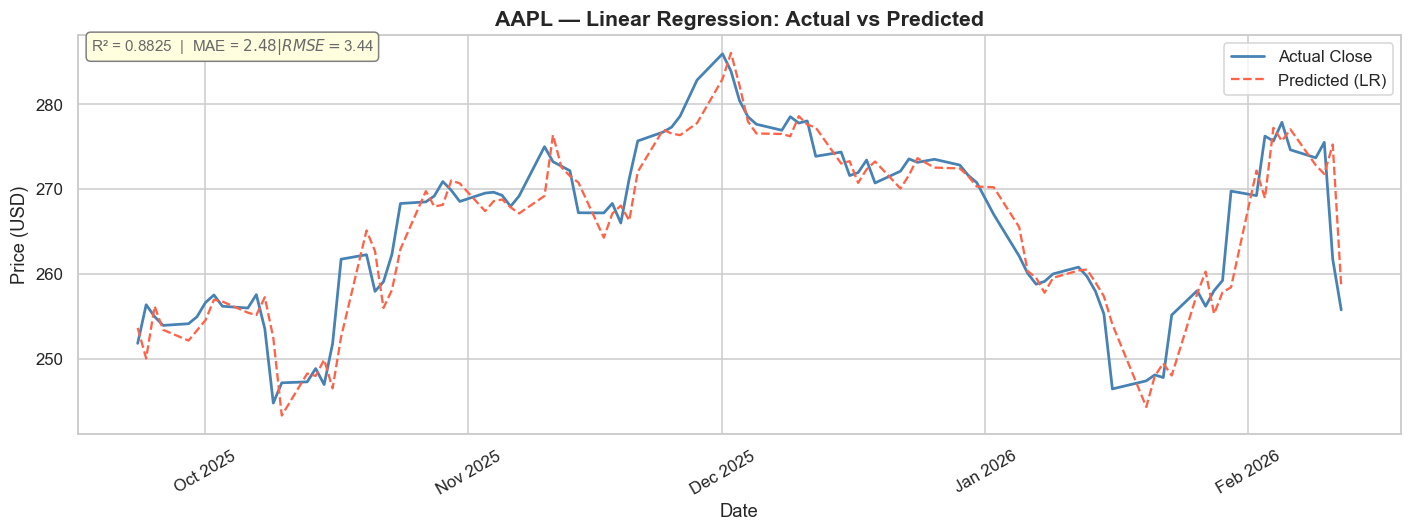

In [12]:
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(dates_test, y_test,    color='steelblue',  linewidth=1.8, label='Actual Close')
ax.plot(dates_test, y_pred_lr, color='tomato',     linewidth=1.5,
        linestyle='--', label='Predicted (LR)')
ax.set_title(f'{TICKER} — Linear Regression: Actual vs Predicted', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', rotation=30)
ax.legend()
ax.annotate(f'R² = {r2_lr:.4f}  |  MAE = ${mae_lr:.2f}  |  RMSE = ${rmse_lr:.2f}',
            xy=(0.01, 0.96), xycoords='axes fraction',
            fontsize=10, color='dimgray',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', edgecolor='gray'))
plt.tight_layout()
plt.show()

## 7. Random Forest Regressor Model

In [ ]:
rf = RandomForestRegressor(n_estimators=800, min_samples_split=10, min_samples_leaf=2, 
                            max_features='sqrt', max_depth=30, bootstrap=False)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf  = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf   = r2_score(y_test, y_pred_rf)

print("── Random Forest Results ──────────────────")
print(f"  MAE  : ${mae_rf:.4f}")
print(f"  RMSE : ${rmse_rf:.4f}")
print(f"  R²   : {r2_rf:.4f}")

── Random Forest Results ──────────────────
  MAE  : $14.1303
  RMSE : $16.6916
  R²   : -1.7711


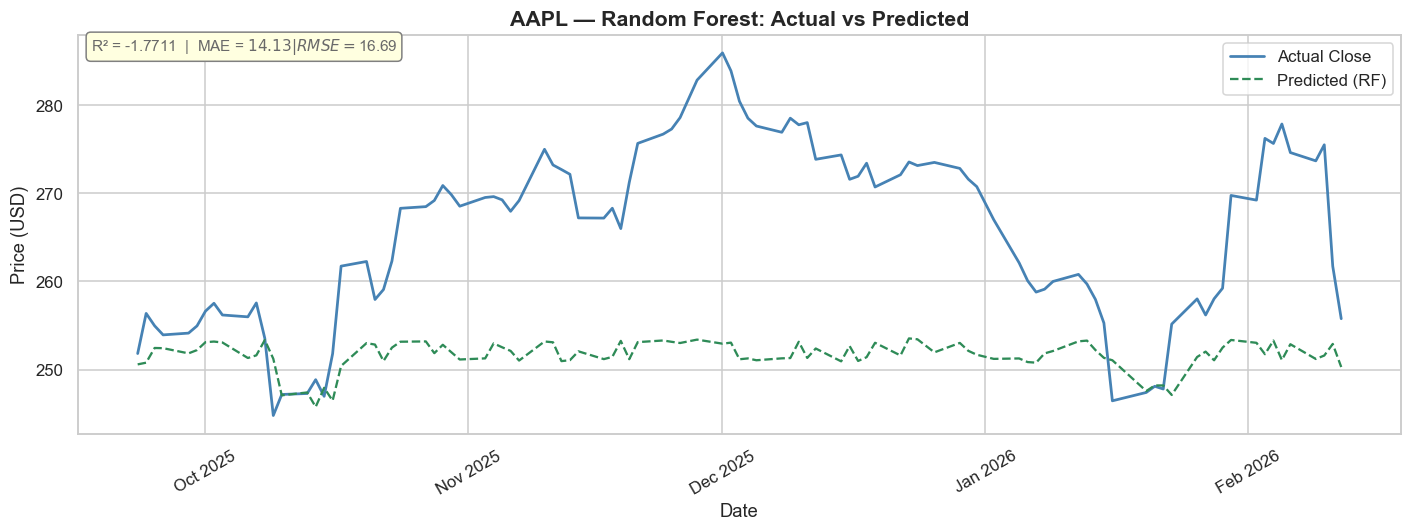

In [36]:
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(dates_test, y_test,    color='steelblue', linewidth=1.8, label='Actual Close')
ax.plot(dates_test, y_pred_rf, color='seagreen',  linewidth=1.5,
        linestyle='--', label='Predicted (RF)')
ax.set_title(f'{TICKER} — Random Forest: Actual vs Predicted', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', rotation=30)
ax.legend()
ax.annotate(f'R² = {r2_rf:.4f}  |  MAE = ${mae_rf:.2f}  |  RMSE = ${rmse_rf:.2f}',
            xy=(0.01, 0.96), xycoords='axes fraction',
            fontsize=10, color='dimgray',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', edgecolor='gray'))
plt.tight_layout()
plt.show()

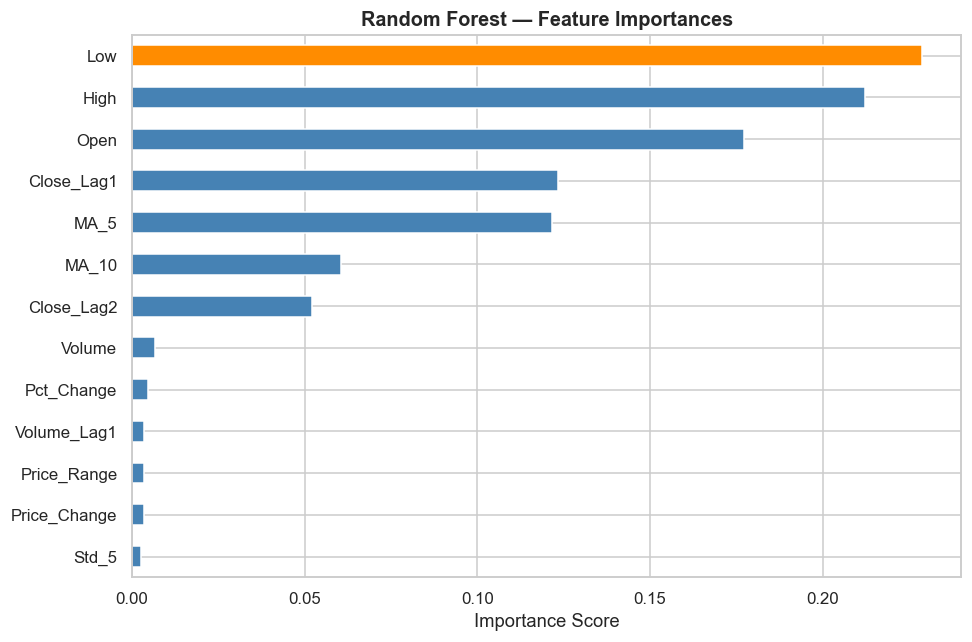

In [37]:
# Feature Importance (Random Forest)
importances = pd.Series(rf.feature_importances_, index=FEATURES).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(9, 6))
colors = ['steelblue' if v < importances.max() else 'darkorange' for v in importances]
importances.plot(kind='barh', ax=ax, color=colors, edgecolor='white')
ax.set_title('Random Forest — Feature Importances', fontsize=13, fontweight='bold')
ax.set_xlabel('Importance Score')
plt.tight_layout()
plt.show()

## 8. Model Comparison

In [38]:
# Side-by-side metric comparison
metrics = pd.DataFrame({
    'Model' : ['Linear Regression', 'Random Forest'],
    'MAE'   : [mae_lr,  mae_rf],
    'RMSE'  : [rmse_lr, rmse_rf],
    'R²'    : [r2_lr,   r2_rf]
}).set_index('Model')

print("── Model Comparison ───────────────────────")
print(metrics.round(4).to_string())
metrics.round(4)

── Model Comparison ───────────────────────
                       MAE     RMSE      R²
Model                                      
Linear Regression   2.4822   3.4378  0.8825
Random Forest      14.1303  16.6916 -1.7711


,MAE,RMSE,R²
Model,,,
Linear Regression,2.4822,3.4378,0.8825
Random Forest,14.1303,16.6916,-1.7711


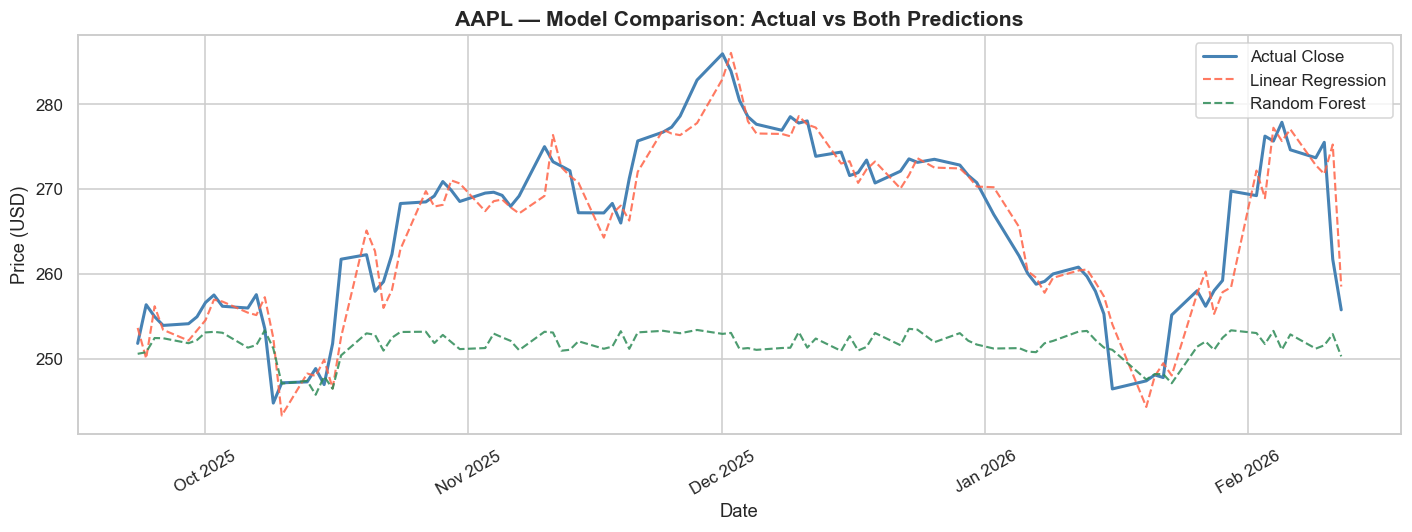

In [39]:
# Overlay both predictions
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(dates_test, y_test,    color='steelblue',  linewidth=2.0, label='Actual Close')
ax.plot(dates_test, y_pred_lr, color='tomato',     linewidth=1.4,
        linestyle='--', alpha=0.85, label='Linear Regression')
ax.plot(dates_test, y_pred_rf, color='seagreen',   linewidth=1.4,
        linestyle='--', alpha=0.85, label='Random Forest')
ax.set_title(f'{TICKER} — Model Comparison: Actual vs Both Predictions',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', rotation=30)
ax.legend()
plt.tight_layout()
plt.show()

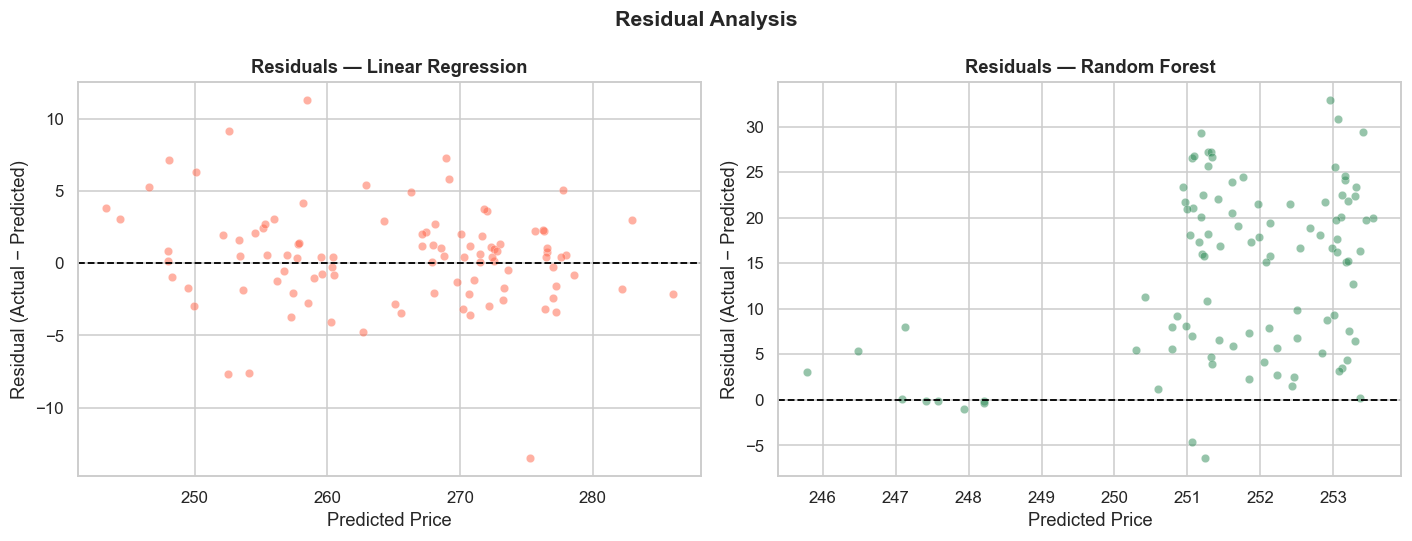

In [40]:
# Residual plots
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

residuals_lr = y_test - y_pred_lr
residuals_rf = y_test - y_pred_rf

for ax, residuals, label, color in zip(
        axes,
        [residuals_lr, residuals_rf],
        ['Linear Regression', 'Random Forest'],
        ['tomato', 'seagreen']):
    ax.scatter(y_pred_lr if label == 'Linear Regression' else y_pred_rf,
               residuals, alpha=0.5, color=color, edgecolors='white', linewidth=0.3, s=30)
    ax.axhline(0, color='black', linewidth=1.2, linestyle='--')
    ax.set_title(f'Residuals — {label}', fontweight='bold')
    ax.set_xlabel('Predicted Price')
    ax.set_ylabel('Residual (Actual − Predicted)')

plt.suptitle('Residual Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

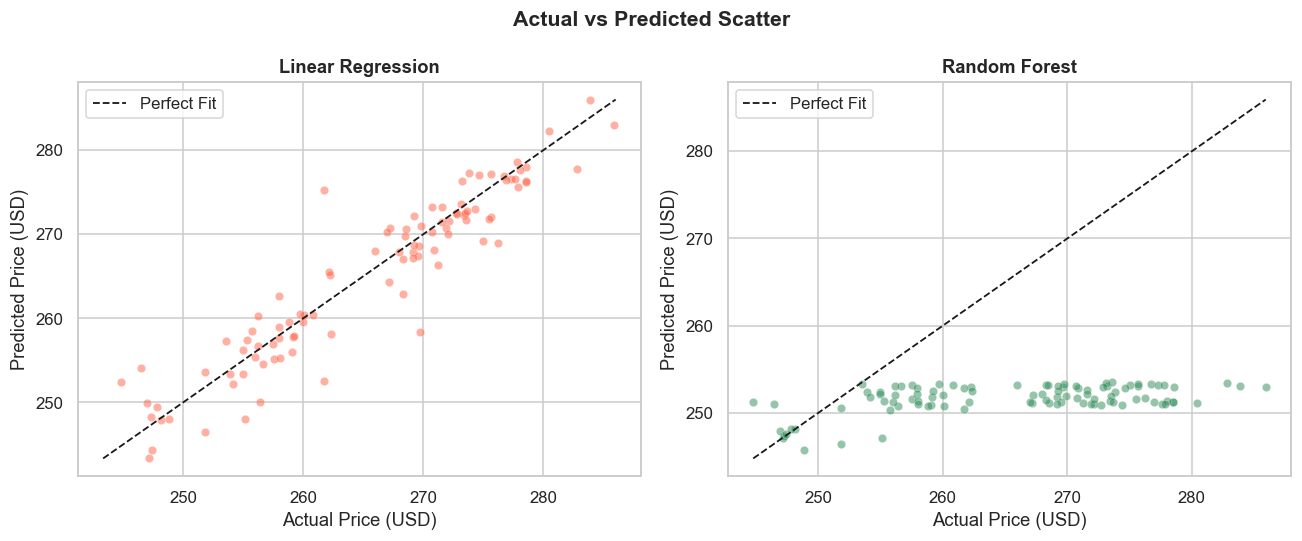

In [41]:
# Scatter: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, preds, label, color in zip(
        axes,
        [y_pred_lr, y_pred_rf],
        ['Linear Regression', 'Random Forest'],
        ['tomato', 'seagreen']):
    ax.scatter(y_test, preds, alpha=0.5, color=color, edgecolors='white', linewidth=0.3, s=30)
    mn, mx = min(y_test.min(), preds.min()), max(y_test.max(), preds.max())
    ax.plot([mn, mx], [mn, mx], 'k--', linewidth=1.2, label='Perfect Fit')
    ax.set_title(f'{label}', fontweight='bold')
    ax.set_xlabel('Actual Price (USD)')
    ax.set_ylabel('Predicted Price (USD)')
    ax.legend()

plt.suptitle('Actual vs Predicted Scatter', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Predict the Next Trading Day's Price

Use the most recent row of data to predict **tomorrow's closing price** with both models.

In [42]:
# Use the latest available data point
latest_raw = df_feat[FEATURES].iloc[-1].values.reshape(1, -1)
latest_scaled = scaler.transform(latest_raw)

pred_lr_next = lr.predict(latest_scaled)[0]
pred_rf_next = rf.predict(latest_scaled)[0]
last_close   = df_feat['Close'].iloc[-1]
last_date    = df_feat.index[-1].date()

print(f"Last available date   : {last_date}")
print(f"Last closing price    : ${last_close:.2f}")
print(f"")
print(f"── Next-Day Predictions ──────────────────")
print(f"  Linear Regression   : ${pred_lr_next:.2f}  ({(pred_lr_next - last_close)/last_close*100:+.2f}%)")
print(f"  Random Forest       : ${pred_rf_next:.2f}  ({(pred_rf_next - last_close)/last_close*100:+.2f}%)")

Last available date   : 2026-02-12
Last closing price    : $261.73

── Next-Day Predictions ──────────────────
  Linear Regression   : $258.52  (-1.23%)
  Random Forest       : $250.30  (-4.37%)


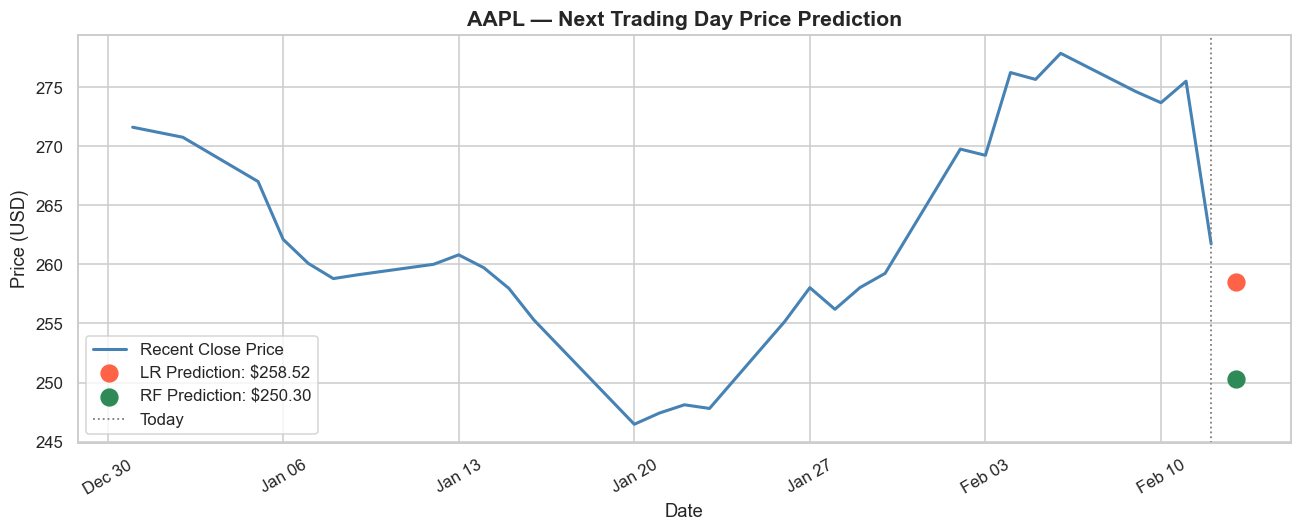

In [43]:
# Visual: recent price + prediction arrow
recent = df_feat['Close'].iloc[-30:]

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(recent.index, recent.values, color='steelblue', linewidth=2, label='Recent Close Price')

# Predicted points
next_date = recent.index[-1] + pd.offsets.BDay(1)
ax.scatter([next_date], [pred_lr_next], color='tomato',   s=120, zorder=5,
           label=f'LR Prediction: ${pred_lr_next:.2f}')
ax.scatter([next_date], [pred_rf_next], color='seagreen', s=120, zorder=5,
           label=f'RF Prediction: ${pred_rf_next:.2f}')
ax.axvline(recent.index[-1], color='gray', linestyle=':', linewidth=1.2, label='Today')

ax.set_title(f'{TICKER} — Next Trading Day Price Prediction', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.tick_params(axis='x', rotation=30)
ax.legend()
plt.tight_layout()
plt.show()